This is a minimal Colab/Jupyter Notebook for regenerating all figures in the paper "Progress towards Deep Learning Genome Assembly: de novo ML-based Read-overlap Graphs and Partial Layout", which was submitted to the ICML Computational Biology Workshop.

Anonymized preprint: https://storage.googleapis.com/progress-towards-assembly/deep_learning_assembly.pdf

Permalink to the source notebook: https://storage.googleapis.com/progress-towards-assembly/deep_learning_assembly.ipynb

--------
All of the required files, as well as model checkpoints, are in the public google cloud bucket gs://progress-towards-assembly/

If you make any modifications that require writing out log files, the scripts will fail unless you copy the bucket to somewhere you have write permissions. Without modifications, read-only access to the public bucket is sufficient.

--------
The scripts below will load the most recent model checkpoint, as well as precomputed edit distances (edit distances take around 6 hours to compute, and the model was trained for 27 hours).

If you want to turn on exporting of Plotly figures, you will have to restart the Colab after installing Kaleido.

As of 2023-05-17, it will run on a GPU-A100-High RAM colab with no modifications.

In [1]:
# This code is only needed for writing.
#from google.colab import auth
#auth.authenticate_user()
#!pip install --quiet nbconvert
#!jupyter nbconvert --to html --embed-images /content/colab.ipynb

In [2]:
import tensorflow as tf

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter

# This will allow viewing the training logs. Note that it also breaks HTML output,
# so we have disabled it here.
#%load_ext tensorboard
#%tensorboard --reload_multifile True --logdir=gs://progress-towards-assembly/dim3large_20230512a/e200


In [3]:
import tensorflow as tf

import numpy as np
import jax
import jax.numpy as jnp
#from jax import random

import os

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

import torch
from tqdm.auto import tqdm


# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
#%load_ext tensorboard

import plotly
!pip install --quiet -U kaleido

!pip install --quiet levenshtein

# Path to the folder where the datasets are
DATASET_PATH = "gs://progress-towards-assembly/"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = DATASET_PATH + "dim3large_20230512a"

!pip install --quiet mpl-scatter-density
import matplotlib.pyplot as plt

import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 464.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 98.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.5/655.5 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 7.1 MB/s eta 0:00:00


In [4]:
# Otherwise Matplotlib is bad about releasing memory
import gc
from matplotlib import pyplot as plt
def collect_garbage():
  plt.figure().clear()
  plt.close('all')
  plt.cla()
  plt.clf()
  gc.collect(generation=2)

In [5]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)


In [6]:

def logarithmic_vector(x, num_bits=16):
  '''Encodes a number x revseribly as a logarithmic vector probability
  For example:
    0 = [1, 0, 0, ...]
    1 = [0, 1, 0 ,...]
    2 = [0, 0, 1, 0, ...]
    3 = [0, 0, 0.42, 0.58, 0, ...]
    4 = [0, 0, 0, 1, 0, ...]
  Based on the mantissa, so that the distance in log-space is preserved

  Note that the first bit is reserved for distance 0.
  '''
  ans = np.zeros(num_bits)
  if x >= 1:
    xl = np.log2(x)
    exp = int(xl)
    mantissa = xl % 1
    ans[int(xl)+1] = 1 - mantissa
    ans[int(xl)+2] = mantissa
  elif x >= 0:
    ans[0] = 1 - x
    ans[1] = x
  else:
    raise ValueError('x must be >= 0')
  return ans

def coarse_onehot(x, num_bits=16, range=256):
  ans = np.zeros(num_bits)
  loc = min(x//(range // num_bits), num_bits-1)
  ans[loc] = 1
  return ans

def adjacent_read(batch, expansion=1, theta=0, prng=np.random.RandomState(None)):
  '''Generates many adjacent reads for each read in batch '''
  def adjacent(x):
    '''First shifts the entire k-mer by 'roll' to simulate overlap.

    Then, puts in theta percent substitutions into a k-mer x (as array of 0,1,2,3)

    Note that the actual edit distance for the returned string may not be d
    '''
    length = len(x)
    roll = prng.randint(-length, length)
    x = np.concatenate([x, prng.randint(4, size=length)])
    x = np.roll(x, roll)[:length]
    mask = (prng.uniform(size=length) < theta)
    adds = prng.randint(4, size=length) * mask
    x = (x + adds) % 4
    return x.astype(np.uint8), np.absolute(roll)
  read_array = []
  for x in batch:
    read_array.extend([(x,) + adjacent(x) for _ in range(expansion)] )
  return read_array


In [7]:
import tensorflow as tf
import jax
from jax import numpy as jnp
import numpy as np

def convert_fasta_to_numpy(string):
  '''Converts ACGT or acgt to 3021'''
  return ((np.frombuffer(string.upper().encode(), dtype='uint8') % 7 +1) % 5)%4


with tf.io.gfile.GFile(DATASET_PATH + "NC_045512.2.fasta", "r") as f:
  f.read(11)
  data = f.read().replace('\n', '')
  data = convert_fasta_to_numpy(data)

In [8]:
from tqdm.auto import tqdm
def sample_reads(k, fasta, size=1, theta=0.01, seed=1729):
  '''Samples reads from a fasta'''
  seq_length = len(fasta) - k
  prng = np.random.RandomState(seed)
  read_array = []
  positions = []
  for _ in range(size):
    loc = prng.randint(seq_length)
    positions.append(loc)
    read = fasta[loc:loc+k]
    num_mutations = sum(prng.uniform(size=k)<theta)
    for _ in range(num_mutations):
      if prng.uniform() < 0.33: # insertion
        rloc = prng.randint(0, k)
        roll = prng.randint(0, k)
        read[rloc:] = np.roll(read[rloc:], roll)
        read[rloc] = (read[rloc] + prng.randint(1,4)) % 4
      elif prng.uniform() <0.66: # deletion
        rloc = prng.randint(0, k)
        roll = prng.randint(0, k)
        read[0] = (read[0] + prng.randint(1,4)) % 4
        read[:rloc] = np.roll(read[:rloc], -roll)
      else:
        rloc = prng.randint(0, k)
        read[rloc] = (read[rloc] + prng.randint(1,4)) % 4
    read_array.append(read.reshape((1,-1))) 
  return np.concatenate(read_array, axis=0), positions


In [9]:
# Generate actual sampled reads for assembly
k = 256
depth_of_coverage = 200
reads, locations = sample_reads(k, data, size=(len(data)*depth_of_coverage//k), theta=0.01)
sorted_reads = np.concatenate([x.reshape((1,-1)) for x, _ in sorted(zip(reads, locations), key=lambda x: x[1])], axis=0)
sorted_locations = sorted(locations)

In [10]:
train_batch = adjacent_read(reads, expansion=1, theta=0.01)
train_loader = torch.utils.data.DataLoader(train_batch, batch_size=512, shuffle=True,
                                           num_workers=1, collate_fn=numpy_collate)

test_dataset = adjacent_read(reads, expansion=1, theta=0.01, prng=np.random.RandomState(1))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True,
                                           num_workers=1, collate_fn=numpy_collate)

val_dataset = adjacent_read(reads, expansion=1, theta=0.01, prng=np.random.RandomState(0))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=True,
                                           num_workers=1, collate_fn=numpy_collate)


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax
import jax
import jax.numpy as jnp

class Encoder(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = x.reshape([x.shape[0], -1, 1])
    y1 = nn.Conv(features=4, kernel_size=(4,), strides=4, name='1mer')(x)
    y2 = nn.Conv(features=4**2, kernel_size=(4*2,), strides=4, name='2mer')(x)
    y3 = nn.Conv(features=4**3, kernel_size=(4*3,), strides=4, name='3mer')(x)
    y4 = nn.Conv(features=4**4 // 4, kernel_size=(4*4,), strides=4, name='4mer')(x)
    y5 = nn.Conv(features=4**5 // 8, kernel_size=(4*5,), strides=4, name='5mer')(x)
    y6 = nn.Conv(features=4**6 // 16, kernel_size=(4*6,), strides=4, name='6mer')(x)
    y7 = nn.Conv(features=4**7 // 32, kernel_size=(4*7,), strides=4, name='7mer')(x)
    y8 = nn.Conv(features=4**8 // 64, kernel_size=(4*8,), strides=4, name='8mer')(x)
    y9 = nn.Conv(features=4**9 // 128, kernel_size=(4*9,), strides=4, name='9mer')(x)
    y10 = nn.Conv(features=4**10 // 256, kernel_size=(4*10,), strides=4, name='10mer')(x)

    y4 = nn.max_pool(y4, window_shape=(4,), strides=(4,))
    y5 = nn.max_pool(y5, window_shape=(5,), strides=(5,))
    y6 = nn.max_pool(y6, window_shape=(6,), strides=(6,))
    y7 = nn.max_pool(y7, window_shape=(7,), strides=(7,))
    y8 = nn.max_pool(y8, window_shape=(8,), strides=(8,))
    y9 = nn.max_pool(y9, window_shape=(9,), strides=(9,))
    y10 = nn.max_pool(y10, window_shape=(10,), strides=(10,))

    y1 = y1.reshape(y1.shape[0], -1)
    y2 = y2.reshape(y2.shape[0], -1)
    y3 = y3.reshape(y3.shape[0], -1)
    y4 = y4.reshape(y4.shape[0], -1)
    y5 = y5.reshape(y5.shape[0], -1)
    y6 = y6.reshape(y6.shape[0], -1)
    y7 = y7.reshape(y7.shape[0], -1)
    y8 = y8.reshape(y8.shape[0], -1)
    y9 = y9.reshape(y9.shape[0], -1)
    y10 = y10.reshape(y10.shape[0], -1)    

    y = jnp.concatenate([y1, y2, y3, y4, y5, y6, y7, y8, y9, y10], axis=1)
    y = nn.gelu(y)
    y = nn.Dense(512)(y)
    y = nn.gelu(y)
    y = nn.Dense(256)(y)
    y = nn.gelu(y)
    y = nn.Dense(128)(y)
    y = nn.gelu(y)
    y = nn.Dense(64)(y)
    y = nn.gelu(y)
    y = nn.Dense(32)(y)
    y = nn.gelu(y)
    y = nn.Dense(16)(y)
    y = nn.gelu(y)
    y = nn.Dense(8)(y)
    y = nn.gelu(y)
    y = nn.Dense(3)(y)
    return y


class PredictDistance(nn.Module):
  @nn.compact
  def __call__(self, lx, ly):
    def approx_sqrt(a):
      a = a + 0.01
      def update(x):
        x = x*(x*x + 3*a)/(3*x*x + a)
        return x
      x = a/2
      for _ in range(10):
        x = update(x)
      return x
    z = ((lx - ly)**2).sum(axis=1)
    z = approx_sqrt(z)
    return z

class EditEmbedding(nn.Module):
  def setup(self):
    self.encoder = Encoder()
    self.predictdistance = PredictDistance()
  def __call__(self, triple):
    x, y, d = triple
    x = nn.one_hot(x, 4)
    y = nn.one_hot(y, 4)
    lx = self.encoder(x)
    ly = self.encoder(y)
    z = self.predictdistance(lx, ly)
    return z, d


rng = jax.random.PRNGKey(0)
batch = next(iter(test_loader))
encoder = EditEmbedding()
params = encoder.init(rng, batch)['params']
recon_x, y = encoder.apply({'params': params}, batch)

del rng, batch, encoder, params, recon_x, y

In [19]:
class TrainerModule:
  def __init__(self, lr=1e-3, seed=42, log_local=False):
    super().__init__()
    self.lr = lr
    self.seed = seed
    # Create empty model (with no parameters)
    self.model = EditEmbedding()
    # Prepare logging
    self.exmp = next(iter(test_loader))
    self.log_dir = os.path.join(CHECKPOINT_PATH, f'e200')
    if log_local:
      self.logger = SummaryWriter(log_dir = '.')
    else:
      self.logger = SummaryWriter(log_dir = self.log_dir)
    self.create_functions() # Create jitted training and eval functions
    self.init_model() # Initialize model
  def loss_fn(self, params, batch):
    # Reconstruction loss
    pred_d, d = self.model.apply({'params': params}, batch)
    d = d.reshape([d.shape[0], 1])
    pred_d = pred_d.reshape([pred_d.shape[0], 1])
    concat_both = jnp.concatenate([d, pred_d], axis=1)
    weight = 1-jax.nn.sigmoid((jnp.min(concat_both, axis=1)-128.0)/16)
    base_loss = optax.huber_loss(pred_d, d).reshape((d.shape[0],)) * weight
    base_loss = base_loss.mean()
    return base_loss
  def create_functions(self):
    # Training function
    def train_step(state, batch):
      loss, grads = jax.value_and_grad(self.loss_fn)(state.params, batch) # Get loss and gradients for loss
      state = state.apply_gradients(grads=grads) # Optimizer update step
      return state, loss
    self.train_step = jax.jit(train_step)
    def eval_step(state, batch):
      return self.loss_fn(state.params, batch)
    self.eval_step = jax.jit(eval_step)

  def init_model(self):
    #Initialize model
    rng = jax.random.PRNGKey(self.seed)
    rng, init_rng = jax.random.split(rng)
    params = self.model.init(init_rng, self.exmp)['params']
    # Initialize learning rate schedule and optimizer
    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=1e-3,
        warmup_steps=500,
        decay_steps=2500*len(train_loader),
        end_value=1e-6
    )
    optimizer = optax.chain(
        optax.clip(1.0), # Clip gradients at 1
        optax.adam(lr_schedule)
    )
    # Initialize training state
    self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

  def train_model(self, num_epochs=500, starting_epoch=0):
    # Train model until num_epochs
    best_eval = 1e6

    with tqdm(range(starting_epoch+1, num_epochs+1)) as t:
      for epoch_idx in t:
        self.train_epoch(epoch=epoch_idx, tqdm_out=t)
        if epoch_idx % 50 == 0:
          eval_loss = self.eval_model(val_loader)
          self.logger.add_scalar('val/loss', eval_loss, global_step=epoch_idx)
          if eval_loss < best_eval:
            best_eval = eval_loss
            self.save_model(step=epoch_idx)
          self.logger.flush()
  
  def train_epoch(self, epoch, tqdm_out=None):
    # Train model for one epoch, and log avg loss
    losses = []
    train_dataset = adjacent_read(reads, expansion=1, theta=0.01, prng=np.random.RandomState(1000+epoch))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True,
                                           num_workers=4, collate_fn=numpy_collate)
    for batch in train_loader:
      self.state, loss = self.train_step(self.state, batch)
      losses.append(loss)
    losses_np = np.stack(jax.device_get(losses))
    avg_loss = losses_np.mean()
    self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
    if tqdm_out is not None:
      tqdm_out.set_description('loss: ' + str(avg_loss))

  def eval_model(self, data_loader):
    # Test model on all images of a data loader and return avg loss
    losses = []
    batch_sizes = []
    for batch in data_loader:
      loss = self.eval_step(self.state, batch)
      losses.append(loss)
      batch_sizes.append(batch[0].shape[0])
    losses_np = np.stack(jax.device_get(losses))
    batch_sizes_np = np.stack(batch_sizes)
    avg_loss = (losses_np * batch_sizes_np).sum() / batch_sizes_np.sum()
    return avg_loss

  def save_model(self, step=0):
    # Save current model at certain training iteration
    checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params,
                                prefix=f'e200_',
                                step=step, overwrite=False, keep=10)
    
  def load_model(self, step=-1):
    prefix = f'e200_'
    checkpoint_file = checkpoints.latest_checkpoint(self.log_dir, prefix)
    if step < 0:
      if checkpoint_file == None:
        step = None
      else:
        step = int(checkpoint_file.split('_')[-1])
    params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, prefix=prefix, step=step)
    self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)
    if step == None:
      step = 0
    return step

  def load_pretrained_model(self, model_path):
    params = checkpoints.restore_checkpoint(ckpt_dir=model_path, target=self.state.params)
    self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)
    step = 0
    return step


  def checkpoint_exists(self):
    # Check whether a model already exists for this autoencoder
    return tf.io.gfile.exists(self.log_dir)



In [22]:
def load_aligner(total_epochs=10, training_bool=True):
  # Create a trainer module with specified hyperparameters
  trainer = TrainerModule(log_local=(not training_bool))
  step = trainer.load_model()
  if training_bool:
    trainer.train_model(num_epochs=total_epochs, starting_epoch=step)
  trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
  return trainer



In [ ]:
training_bool = False # Setting this to True requires write permissions
trainer_ld = load_aligner(total_epochs=(16100), training_bool=training_bool)


In [25]:
num_params = 0
for k1 in trainer_ld.state.params['encoder'].keys():
  for k2 in trainer_ld.state.params['encoder'][k1]:
    num_params += (np.prod(trainer_ld.state.params['encoder'][k1][k2].shape))
print("Number of trainable parameters: " + str(num_params))


Number of trainable parameters: 130437175


In [26]:
scatter_loader = torch.utils.data.DataLoader(sorted_reads, batch_size=512, shuffle=False,
                                           num_workers=1, collate_fn=numpy_collate)

coords_list = []
for r in iter(scatter_loader):
  r = nn.one_hot(r, 4)
  coords = (trainer_ld.model_bd.encoder(np.asarray(r)))
  coords_list.append(coords)

In [27]:
import pandas as pd
aug_coords_list = []
for i, coord in enumerate(coords_list):
  coord2 = i*np.ones((coord.shape[0], 1))
  coord3 = np.concatenate([coord, coord2], axis=1)
  aug_coords_list.append(coord3)

aug_coords = np.concatenate(aug_coords_list)

df = pd.DataFrame(aug_coords, columns = ['x', 'y', 'z', 'c'])

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib import pyplot as plt

import plotly.express as px
df['Position'] = df['c']/df['c'].max()
fig = px.scatter_3d(df.loc[df['c'] >-1], x='x', y='y', z='z', color='Position',
                    color_continuous_scale=px.colors.sequential.Rainbow)
fig.update_traces(marker_size = 2)
camera = dict(
    eye=dict(x=0.7, y=2.1, z=0.8)
)
fig.update_layout(scene_camera=camera)
if False:  # Set this to true to write output
  plotly.io.write_image(fig, '3D.png', scale=5)
fig.show()

collect_garbage()

<Figure size 640x480 with 0 Axes>

In [29]:
df2 = df.copy()
center = df.mean(axis=0)

df2['c'] /= df2['c'].max() # Normalize the distance along the genome


# find the centre of the sphere
from scipy.optimize import least_squares
def f(sphere, df):
  '''Sphere is [x,y,z,r]'''
  xyz = df[['x', 'y', 'z']].to_numpy()
  centre = sphere[:3]
  ans =  ((xyz - centre)**2).sum(axis=1) - sphere[3]**2
  return ans
centre = least_squares(f, 10*np.ones(4), args=(df2,))

df2['x'] = (df2['x'] - centre.x[0]) / centre.x[3]
df2['y'] = (df2['y'] - centre.x[1]) / centre.x[3]
df2['z'] = (df2['z'] - centre.x[2]) / centre.x[3]

def g(cylinder, df):
  '''Cylinder axis is [x, y, z]'''
  xyz = df[['x', 'y', 'z']].to_numpy()
  cylinder = cylinder / np.sqrt(np.sum((cylinder**2)))
  ans = (xyz * cylinder).sum(axis=1)
  return ans
cylinder = least_squares(g, np.ones(3), args=(df2,))
cylinder_axis = cylinder.x / np.sqrt(np.sum((cylinder.x**2)))
#print(cylinder_axis)
  
def rot(cylinder_axis, df):
  print(cylinder_axis)
  dfx = df['x']
  dfy = df['y']
  dfz = df['z']
  x, y, z = cylinder_axis
  thet1 = -np.arctan(y/x)
  x_ = np.cos(thet1)*x - np.sin(thet1)*y
  y_ = np.sin(thet1)*x + np.cos(thet1)*y

  cylinder_axis = (x_, y_, z)
  x, y, z = cylinder_axis
  thet2 = -np.arctan(x/z)
  z_ = np.cos(thet2)*z - np.sin(thet2)*x
  x_ = np.sin(thet2)*z + np.cos(thet2)*x
  cylinder_axis = (x_, y, z_)
  #print(cylinder_axis)

  dfx_ = np.cos(thet1)*dfx - np.sin(thet1)*dfy
  dfy_ = np.sin(thet1)*dfx + np.cos(thet1)*dfy
  dfx = dfx_
  dfy = dfy_
  dfz_ = np.cos(thet2)*dfz - np.sin(thet2)*dfx
  dfx_ = np.sin(thet2)*dfz + np.cos(thet2)*dfx
  dfz = dfz_
  dfx = dfx_
  df2 = df.copy()
  df2['x'] = dfx
  df2['y'] = dfy
  df2['z'] = dfz
  return df2

df2 = rot(cylinder_axis, df2)

def unroll(df):
  '''Unrolls a cylinder around the z axis with radius 1'''
  df2 = df.copy()
  dfx = df['x']
  dfy = df['y']
  dfz = df['z']

  df0 = np.arctan(dfx/dfy) + (dfy < 0)*3.14  + 3.14/2
  df2['theta'] = df0
  return df2

df2 = unroll(df2)

df2['Position'] = df2['c']
df2['angle'] = df2['theta']
fig = px.scatter(df2.loc[df2['c'] >-1], x='angle', y='z', color='Position',
                  color_continuous_scale=px.colors.sequential.Rainbow)
fig.update_traces(marker_size = 3)
fig.update_xaxes(range=[0, 6.28], row=1, col=1)
fig.update_layout(
  plot_bgcolor='white'
)
fig.show()
if False: # Set this to true to write output
  plotly.io.write_image(fig, '2D.png', scale=5)


collect_garbage()

[-0.5340782   0.81368279 -0.22952296]


<Figure size 640x480 with 0 Axes>

In [30]:
from sklearn.metrics.pairwise import euclidean_distances
XYZ = df[['x', 'y', 'z']].to_numpy()
ed = euclidean_distances(XYZ)
od = euclidean_distances(np.asarray(sorted_locations).reshape([-1, 1]))

In [31]:
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

/usr/local/lib/python3.10/dist-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.10/dist-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



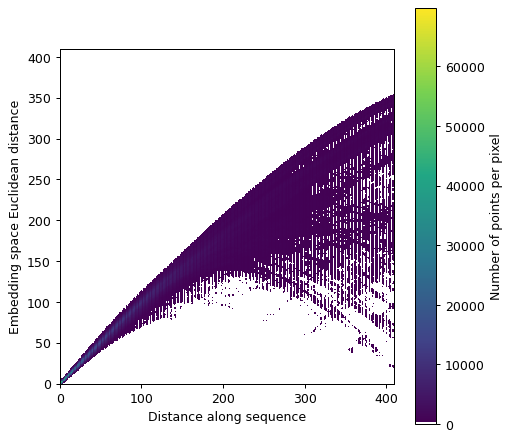

<Figure size 640x480 with 0 Axes>

In [32]:
fig = plt.figure(figsize=(6, 6), dpi=90)
ax = fig.add_subplot(1,1,1, projection='scatter_density')
density = ax.scatter_density(od.flatten(), ed.flatten(), cmap=white_viridis)
ax.set_ylim([0,410])
ax.set_xlim([0,410])
ax.set_xlabel('Distance along sequence')
ax.set_ylabel('Embedding space Euclidean distance')
ax.set_box_aspect(1)
fig.colorbar(density, label='Number of points per pixel')
plt.show()
collect_garbage()

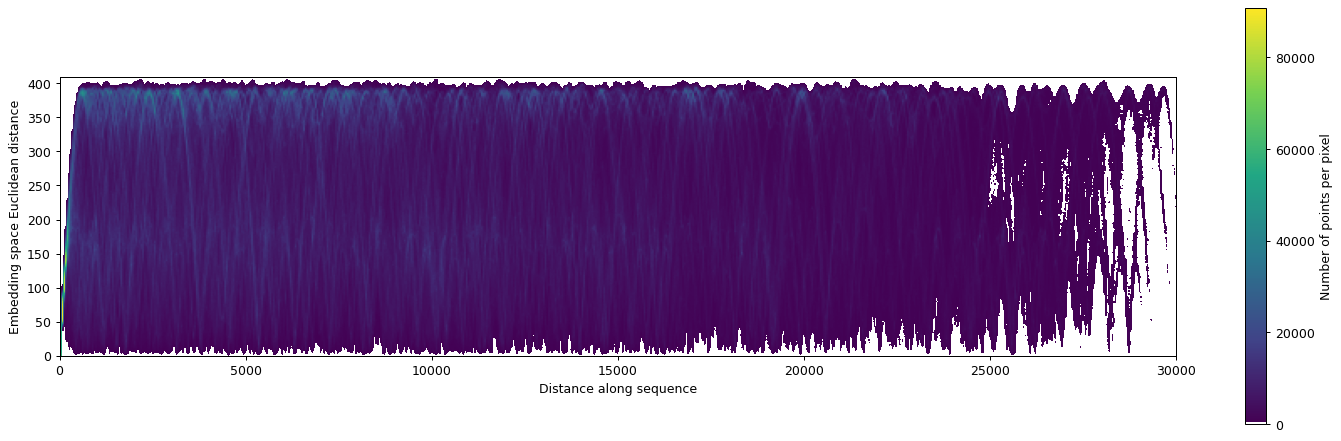

<Figure size 640x480 with 0 Axes>

In [33]:
fig = plt.figure(figsize=(20, 6), dpi=90)
ax = fig.add_subplot(1,1,1, projection='scatter_density')
density = ax.scatter_density(od.flatten(), ed.flatten(), cmap=white_viridis)
ax.set_ylim([0,410])
ax.set_xlim([0,30000])
ax.set_xlabel('Distance along sequence')
ax.set_ylabel('Embedding space Euclidean distance')
ax.set_box_aspect(1/4)
fig.colorbar(density, label='Number of points per pixel')
plt.show()
collect_garbage()


In [34]:
from Levenshtein import distance
from sklearn.metrics.pairwise import pairwise_distances, paired_distances
from tqdm.auto import tqdm

# This function takes upwards of 6 hours to compute, so we've cached the answers here.
cache_path = DATASET_PATH + "dim3large_20230512a/e200/edit_distances.npy"
try:
  with tf.io.gfile.GFile(cache_path, "rb") as f:
    edit_distances = np.load(f)
except FileNotFoundError:
  edit_distances = pairwise_distances(sorted_reads, sorted_reads, metric=distance)
  if False:
    with tf.io.gfile.GFile(cache_path, "w") as f:
      np.save(f, edit_distances)



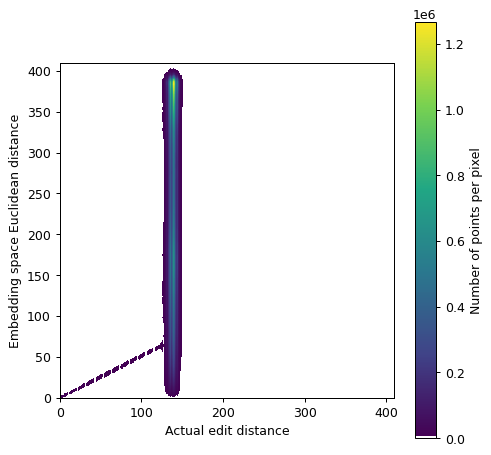

<Figure size 640x480 with 0 Axes>

In [35]:
fig = plt.figure(figsize=(6, 6), dpi=90)
ax = fig.add_subplot(1,1,1, projection='scatter_density')
density = ax.scatter_density(edit_distances.flatten(), ed.flatten(), cmap=white_viridis)
ax.set_ylim([0,410])
ax.set_xlim([0,410])
ax.set_xlabel('Actual edit distance')
ax.set_ylabel('Embedding space Euclidean distance')
ax.set_box_aspect(1)
fig.colorbar(density, label='Number of points per pixel')
plt.show()
collect_garbage()
